In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 로드

In [2]:
import numpy as np
X=np.load('/content/drive/MyDrive/딥러닝_20조/제출용_소스코드/X_test.npy')

In [ ]:
X.shape

(2000, 256, 256, 3)

# 커스텀 함수

In [3]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def f1s(threshold=0.7):
    def f1_score(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        y_pred = K.cast(y_pred, 'float32')

        # 임계값을 적용하여 이진 분류 수행
        y_pred = K.cast(K.greater(y_pred, threshold), K.floatx())

        # 픽셀 단위로 배열을 평탄화
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)

        # 정밀도 계산
        precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())

        # 재현율 계산
        recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())

        # F1 점수 계산
        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

        return f1
    return f1_score

In [4]:

import numpy as np


classweights = [0.1, 0.9]  # 0.1는 배경 클래스의 가중치, 0.9은 객체 클래스의 가중치

from tensorflow.keras.losses import binary_crossentropy

def weighted_binary_crossentropy(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    # 이진 크로스엔트로피 손실 계산
    loss = K.binary_crossentropy(y_true, y_pred)

    # 클래스 가중치 적용
    weighted_loss = loss * y_true * classweights[1] + loss * (1 - y_true) * classweights[0]

    return K.mean(weighted_loss)


# 모델 로드

In [5]:
import os
import warnings
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
warnings.filterwarnings('ignore')


In [6]:
import os
from tensorflow.keras.models import load_model

damage_types = ["scratched", "crushed", "separated", "breakage"]

damage_types = ["scratched", "crushed", "separated", "breakage"]

custom_objects = {
    'f1_score': f1s(0.7),
    'weighted_binary_crossentropy': weighted_binary_crossentropy
}

# 각 클래스별 세그멘테이션 모델 로드
for damage in damage_types:
    checkpoint_path = "/content/drive/MyDrive/딥러닝_20조/제출용_소스코드/{}/{}/cp.ckpt".format(damage, damage)
    checkpoint_dir = os.path.dirname(checkpoint_path)
    if damage == "scratched":
        model_scratched = load_model(checkpoint_path, custom_objects=custom_objects)
    elif damage == "crushed":
        model_crushed = load_model(checkpoint_path, custom_objects=custom_objects)
    elif damage == "separated":
        model_separated = load_model(checkpoint_path, custom_objects=custom_objects)
    elif damage == "breakage":
        model_breakage = load_model(checkpoint_path, custom_objects=custom_objects)


# 서비스 구현

1/1 [==============================] - 2s 2s/step


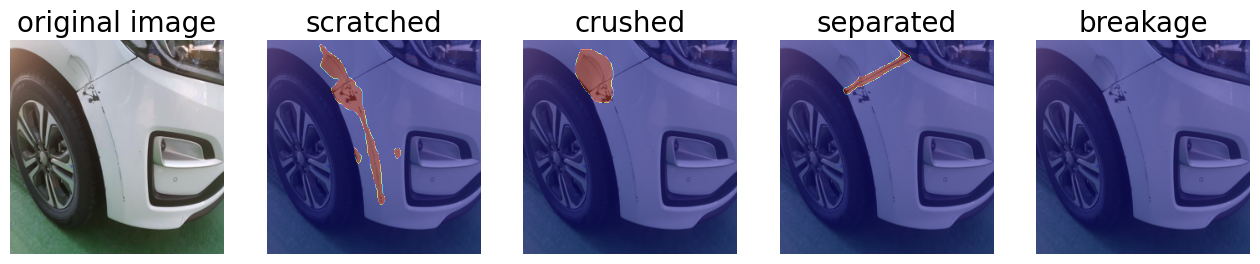

In [7]:
# 픽셀당 가격 설정
prices_per_pixel = {
    "scratched": 0.6,
    "crushed": 1.2,
    "separated": 1.2,
    "breakage": 2.4
}


# 이미지 인덱스 선택
image_index = 1723

# 입력 이미지 지정
input_image = X[image_index]

# Reshape the input image to (1, height, width, channels)
input_image = np.expand_dims(input_image, axis=0)


plt.figure(figsize=(16, 12))

plt.subplot(1, 5, 1)
plt.imshow(input_image[0])  # input_image[0]는 원본 이미지
plt.title('original image', fontsize=20)
plt.axis('off')


# 출력 내용을 저장할 리스트
output = []

# 총 보험료 계산을 위한 변수
total_insurance_cost = 0

# 손상 유형별 예측 mask 생성
for i, damage in enumerate(damage_types):


    if damage == "scratched":
        predicted_mask = model_scratched.predict(input_image)[0]
    elif damage == "crushed":
        predicted_mask = model_crushed.predict(input_image)[0]
    elif damage == "separated":
        predicted_mask = model_separated.predict(input_image)[0]
    elif damage == "breakage":
        predicted_mask = model_breakage.predict(input_image)[0]


    predicted_mask_binary = (predicted_mask > 0.7).astype(np.uint8)
    predicted_mask_binary = predicted_mask_binary * 255
    pixel_count = np.sum(predicted_mask_binary)
    insurance_cost = pixel_count * prices_per_pixel[damage]
    total_insurance_cost += insurance_cost

    # 서브플롯 위치 결정
    if damage == "scratched":
        plt.subplot(1, 5, 2)
    elif damage == "crushed":
        plt.subplot(1, 5, 3)
    elif damage == "separated":
        plt.subplot(1, 5, 4)
    elif damage == "breakage":
        plt.subplot(1, 5, 5)

    plt.imshow(input_image[0])
    plt.imshow(predicted_mask_binary, cmap='jet', alpha=0.5)
    plt.title(damage, fontsize=20)
    plt.axis('off')
    pixel_count=int(pixel_count)
    insurance_cost=int(insurance_cost)

    if insurance_cost != 0: # 손상이 있을 경우만 메세지 출력
      output.append(f"발견된 손상: {damage} -  수리비: {insurance_cost:,}원")

total_insurance_cost=int(total_insurance_cost)
output.append(f"총 수리비: {total_insurance_cost:,}원 예상됩니다 고객님.")

plt.show()
from IPython.display import display, HTML

# 결과를 HTML 형식으로 변환하여 출력
for line in output:
    display(HTML(f"<p style='font-size: 25px;'>{line}</p>"))
